In [1]:
%reload_ext autoreload
%autoreload 2

2025-01-31 11:17:59.438149: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-31 11:17:59.517286: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-31 11:17:59.517324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-31 11:17:59.529482: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-31 11:17:59.552989: I tensorflow/core/platform/cpu_feature_guar

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2025-01-31 11:18:03.185070: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-31 11:18:03.263176: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-31 11:18:03.265866: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Number of batches of 32 images train_ds: 250
Number of batches of 32 images validation_ds: 32
Number of batches of 32 images test_ds: 32


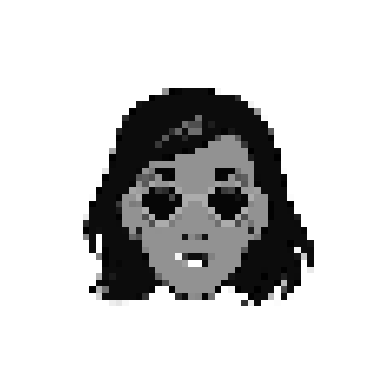

In [2]:
import generacion_cartoon.utils.paths as path
import notebooks.drac_CVAE as CVAE
import tensorflow as tf
import imageio
import tensorflow_probability as tfp
%run "../generacion_cartoon/data/0.1-drac-make_dataset.ipynb"
import time
import numpy as np
import glob


In [28]:
latent_dim = 90

epochs = 500

model = CVAE.CVAE(latent_dim)

In [4]:
def plot_latent_images(model, num_images_x, epoch, im_size=56, save=True, first_epoch=False, f_ep_count=0):
    
    # Create image matrix 
    image_width = im_size*num_images_x
    image_height = image_width
    image = np.zeros((image_height, image_width))

    # Create list of values which are evenly spaced wrt probability mass

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, num_images_x))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, num_images_x))

    # For each point on the grid in the latent space, decode and
    # copy the image into the image array
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (im_size, im_size))
            image[i * im_size: (i + 1) * im_size,
                  j * im_size: (j + 1) * im_size] = digit.numpy()
    

    # Plot the image array
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')

    # Potentially save, with different formatting if within first epoch
    if save and first_epoch:
        name = 'tf_grid_at_epoch_{:04d}.{:04d}.png'.format(epoch, f_ep_count)
        plt.savefig(path.data_created_dir(name))
    elif save:
        name = 'tf_grid_at_epoch_{:04d}.png'.format(epoch)
        plt.savefig(path.data_created_dir(name))

In [29]:
tf.config.run_functions_eagerly(True)
#plot_latent_images(model=model, num_images_x=20, epoch=0)
optimizer = tf.keras.optimizers.Adam(1e-4)
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for idx, train_x in enumerate(train_ds):
        CVAE.train_step(model, train_x, optimizer)
        #if epoch == 1 and idx % 75 == 0:
            #plot_latent_images(model=model, num_images_x=20, epoch=epoch, first_epoch=True, f_ep_count=idx)          
    end_time = time.time()
    loss = tf.keras.metrics.Mean()
    for test_x in test_ds:
        loss(CVAE.compute_loss(model, test_x))
    elbo = -loss.result()
    #display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
 #   if epoch != 1:
        #plot_latent_images(model, 20, epoch=epoch)

Epoch: 1, Test set ELBO: -653.505126953125, time elapse for current epoch: 8.572866678237915
Epoch: 2, Test set ELBO: -603.1679077148438, time elapse for current epoch: 8.16273021697998
Epoch: 3, Test set ELBO: -582.5429077148438, time elapse for current epoch: 8.090718984603882
Epoch: 4, Test set ELBO: -560.8153076171875, time elapse for current epoch: 8.231002569198608
Epoch: 5, Test set ELBO: -548.1552734375, time elapse for current epoch: 7.4378790855407715
Epoch: 6, Test set ELBO: -542.3662719726562, time elapse for current epoch: 7.3361358642578125
Epoch: 7, Test set ELBO: -533.9795532226562, time elapse for current epoch: 7.086307525634766
Epoch: 8, Test set ELBO: -528.4794921875, time elapse for current epoch: 6.911956310272217
Epoch: 9, Test set ELBO: -523.6066284179688, time elapse for current epoch: 6.221456527709961
Epoch: 10, Test set ELBO: -518.1276245117188, time elapse for current epoch: 7.1023924350738525
Epoch: 11, Test set ELBO: -514.4335327148438, time elapse for cu

In [14]:
name_gif = f'grid_epoch={epochs}.gif'
anim_file = path.data_created_dir(name_gif)
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(os.path.join(path.data_created_dir(),'tf_grid*.png'))
    filenames = sorted(filenames)
    for filename in filenames:
        #print(filename)
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
for file in filenames:
    os.remove(file)

/tmp/ipykernel_395486/3501547342.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_395486/3501547342.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [30]:
path_models = path.models_dir("modelo_30epochs.weights.h5")

In [31]:
# Guardar los pesos del modelo
model.save_weights(path_models)


In [32]:
model.load_weights(path_models)

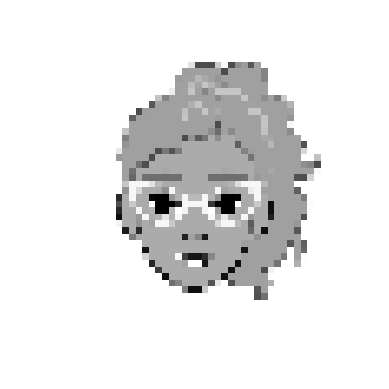

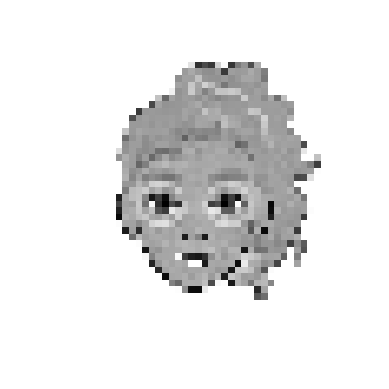

In [33]:
for img in test_ds:
    mean, logvar = model.encode(img)
    z = model.reparameterize(mean, logvar)
    generated_image = model.decode(z, apply_sigmoid=True)
    num_img = 20
    plt.imshow(img[num_img], cmap='gray')
    plt.axis('off')
    plt.show()

    plt.imshow(generated_image[num_img].numpy().squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()
    break